<a href="https://colab.research.google.com/github/DriverFit/Machine_Learning/blob/main/CNN_imageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proses Pengambilan Data**

In [ ]:
!pip install -U -q PyDrive2
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Menarik file FaceImages.zip
id='16wbMvqiUr3joKy-nUxjcfb8Qn-7M4-Me' # ini id dari link drive nya
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('FaceImages.zip')

In [ ]:
# Menarik file horse-or-human.zip, tidak perlu dirun karena hanya untuk testing
id2='1ZDApbrjwIsGsAeEABXG4Pz9OkpwT-iLt' # ini id dari link drive nya
downloaded2 = drive.CreateFile({'id':id})
downloaded2.GetContentFile('horse-or-human.zip')

KeyboardInterrupt: ignored

**Unzip file yang telah diperoleh serta membuat directory**

In [ ]:
import zipfile
import os

In [ ]:
zip_ref = zipfile.ZipFile('./FaceImages.zip', 'r')
zip_ref.extractall('tmp/FaceImages')
zip_ref.close()

In [ ]:
train_active_dir = os.path.join('tmp/FaceImages/Active Subjects')
train_fatigue_dir = os.path.join('tmp/FaceImages/Fatigue Subjects')

**Memeriksa folder dan Mencoba Tampilkan Gambar**

In [ ]:
os.listdir(train_active_dir)[:5]

['img_c_11397.jpg',
 'image_17748.jpg',
 'img_e_2970.jpg',
 'img_h_17010.jpg',
 'img_h_1440 - Copy.jpg']

In [ ]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [ ]:
img = cv2.imread(os.path.join(train_active_dir,'img_c_11397.jpg'))

In [ ]:
img.shape

(720, 1080, 3)

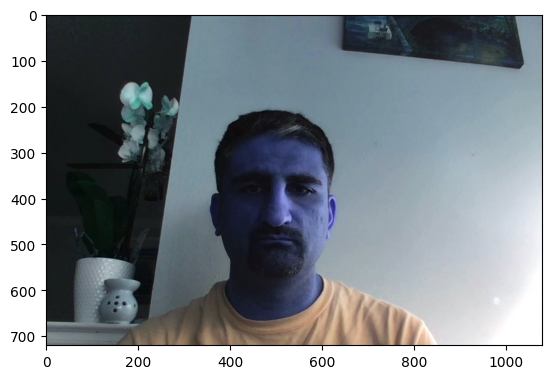

In [ ]:
plt.imshow(img)

Warnanya terlihat aneh karena OpenCV membaca foto dengan format GBR, sedangkan Matplotlib membacanya dengan format RGB.

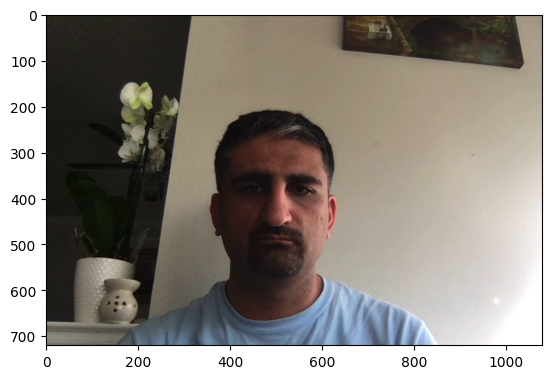

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

Semua file sejauh ini tidak ada masalah secara ekstensi (jpg) dan ukuran (di atas 60kb). Oleh karena itu, mungkin tidak perlu cleansing.

**Memulai dengan Data**

In [ ]:
import tensorflow as tf

In [ ]:
data_dir = os.path.join('./tmp/FaceImages')

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 9120 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

batch berisi 32 gambar, dengan ukuran 256 x 256, dan 3 channel warna (RGB)

In [ ]:
batch[1]

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int32)

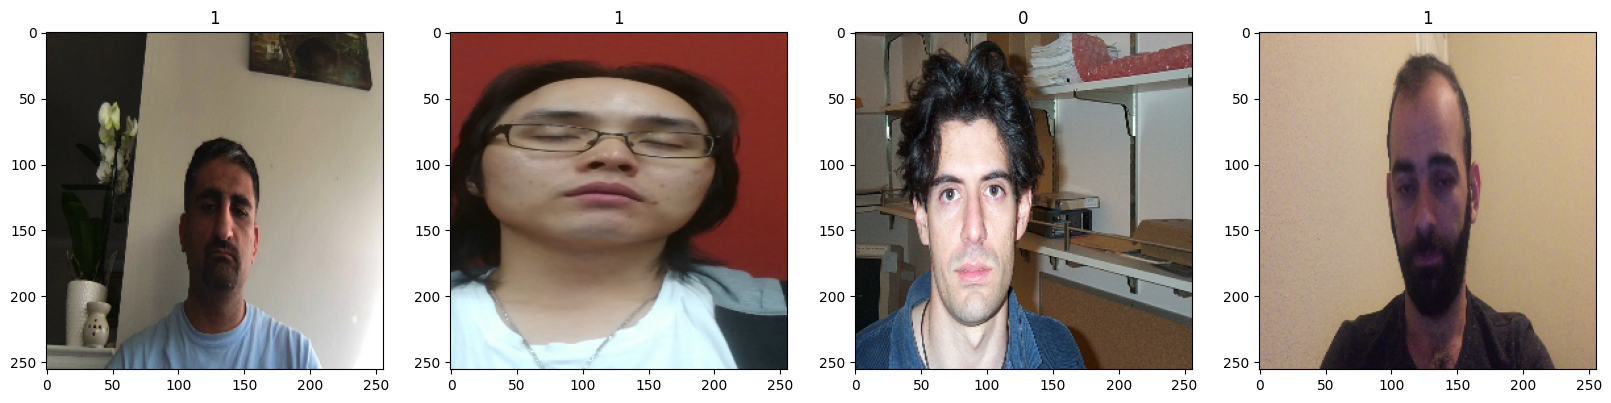

In [ ]:
#visualiz
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

Dari gambar di atas terlihat angka 0 menunjukkan class active dan angka 1 menunjukkan class fatigue.

**Preprocess Data**

In [ ]:
data = data.map(lambda x,y: (x/255, y)) #perform transformation in pipeline, x=images, y =labels

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next() #next batch

In [ ]:
batch[0].max()

1.0

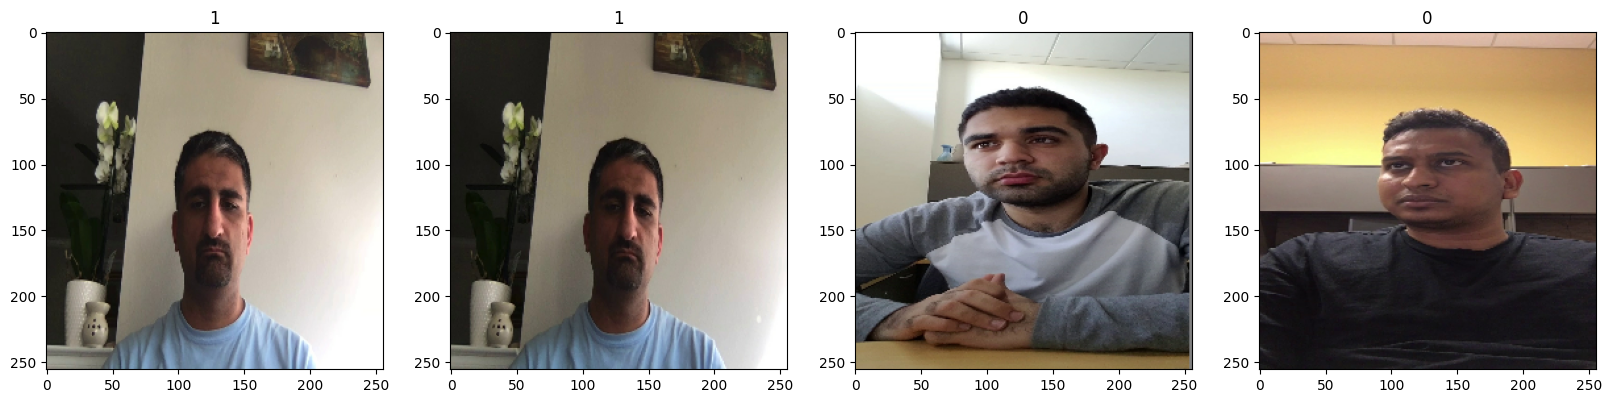

In [ ]:
#visualize
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(float))
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
len(data)

285

$$
285 \times 32 = 9120
$$

Dalam 1 batch ada 32 gambar. Karena ada 285 batch, totalnya 9120. Hal ini sudah sesuai dengan total gambar yang dimiliki, yaitu 9120.

In [ ]:
train_size = int(len(data)*.7)+1 #Total batches for training the deep learning model
val_size = int(len(data)*.2) #Total batches for validation for evaluating the model
test_size = int(len(data)*.1) #Total batches for testing

# train_size + val_size + test_size = len(data)

In [ ]:
print(train_size, val_size, test_size, train_size+val_size+test_size)

200 57 28 285


In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

**Deep Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
#augmentasi
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

In [ ]:
#asli
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
#optimezer test
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

**Train**

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
200/200 [==============================] - 543s 3s/step - loss: 0.4890 - accuracy: 0.7544 - val_loss: 0.3961 - val_accuracy: 0.8136
Epoch 2/20
200/200 [==============================] - 499s 2s/step - loss: 0.3849 - accuracy: 0.8188 - val_loss: 0.3627 - val_accuracy: 0.8141
Epoch 3/20
200/200 [==============================] - 552s 3s/step - loss: 0.3409 - accuracy: 0.8452 - val_loss: 0.3431 - val_accuracy: 0.8498
Epoch 4/20
200/200 [==============================] - 564s 3s/step - loss: 0.3183 - accuracy: 0.8592 - val_loss: 0.3313 - val_accuracy: 0.8596
Epoch 5/20
200/200 [==============================] - 553s 3s/step - loss: 0.3023 - accuracy: 0.8675 - val_loss: 0.3214 - val_accuracy: 0.8498
Epoch 6/20
200/200 [==============================] - 560s 3s/step - loss: 0.2930 - accuracy: 0.8700 - val_loss: 0.3295 - val_accuracy: 0.8503
Epoch 7/20
200/200 [==============================] - 552s 3s/step - loss: 0.2823 - accuracy: 0.8780 - val_loss: 0.3119 - val_accuracy: 0.8651

**Plot Performance**

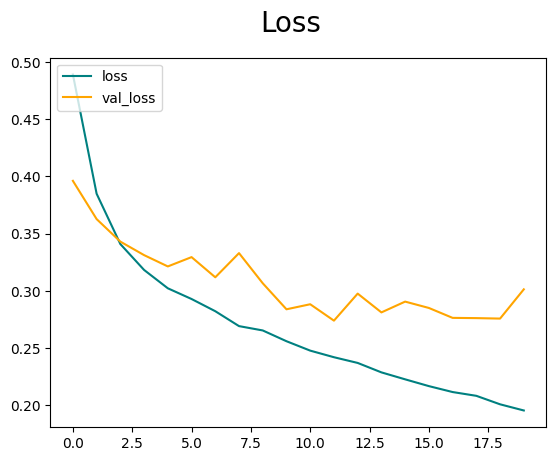

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

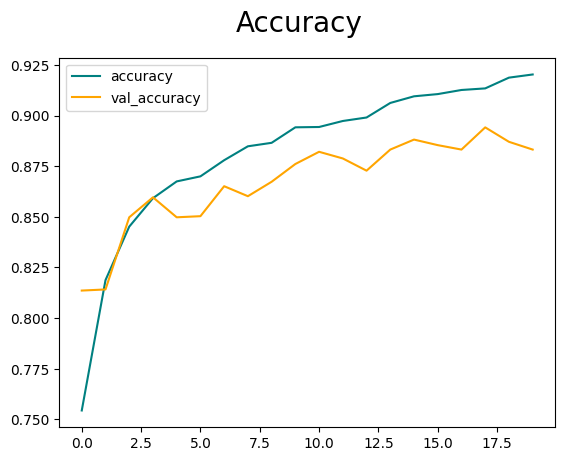

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
len(test)

28

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 477ms/step


In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.91725767, shape=(), dtype=float32) tf.Tensor(0.8272921, shape=(), dtype=float32) tf.Tensor(0.87053573, shape=(), dtype=float32)


In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9172576665878296, Recall:0.8272920846939087, Accuracy:0.8705357313156128


10. Test

In [ ]:
import cv2
import numpy as np

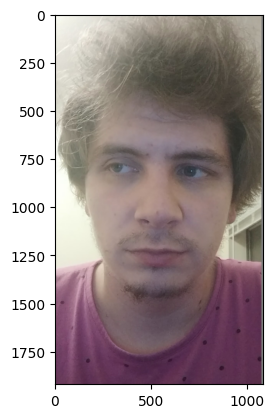

In [ ]:
img = cv2.imread(os.path.join(train_active_dir,'img_k_8820.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

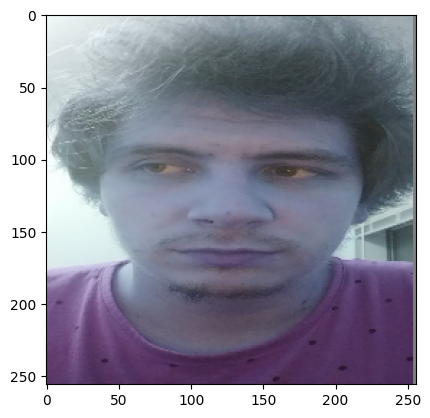

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
resize.shape

TensorShape([256, 256, 3])

In [ ]:
np.expand_dims(resize, 0)

array([[[[243.25    , 251.25    , 250.25    ],
         [242.04297 , 250.04297 , 249.04297 ],
         [242.95312 , 250.95312 , 249.95312 ],
         ...,
         [157.      , 169.      , 175.      ],
         [128.      , 128.      , 128.      ],
         [128.      , 128.      , 128.      ]],

        [[243.09766 , 251.09766 , 250.09766 ],
         [242.      , 250.      , 249.      ],
         [242.      , 250.      , 249.      ],
         ...,
         [157.      , 169.      , 175.      ],
         [128.      , 128.      , 128.      ],
         [128.      , 128.      , 128.      ]],

        [[243.      , 251.      , 250.      ],
         [242.      , 250.      , 249.      ],
         [241.      , 249.      , 248.      ],
         ...,
         [155.      , 169.      , 175.      ],
         [128.      , 128.      , 128.      ],
         [128.      , 128.      , 128.      ]],

        ...,

        [[ 88.      ,  57.      , 102.      ],
         [ 87.171875,  56.171875, 101.171875]

In [ ]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 161ms/step


array([[0.00851082]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Fatigue') #Nilai antara 0.5 - 1 termasuk ke kelas Fatigue karena 1 menunjukkan kelas Fatigue
else:
    print(f'Predicted class is Active')

Predicted class is Active


test 2

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

In [ ]:
uploaded = files.upload()

# define the batch size
batch_size = 10

for i in range(0, len(uploaded.keys()), batch_size):

  # get the images for the current batch
  images = []
  for fn in uploaded.keys()[i:i+batch_size]:
    path = '/content/' + fn
    img = load_img(path, target_size=(300, 300))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images.append(x)

  # predict the classes of the images in the batch
  classes = model.predict(images)

  # print the classes of the images in the batch
  for i in range(len(classes)):
    if classes[i] > 0.5:
      print(uploaded.keys()[i+i] + " is a Active")
    else:
      print(uploaded.keys()[i+i] + " is a Fatigue")

Saving image__0.jpg to image__0.jpg


TypeError: ignored

In [ ]:

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a Active")
  else:
    print(fn + " is a Fatigue")


Saving tes.jpg to tes (1).jpg


InvalidArgumentError: ignored

11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 93ms/step


In [ ]:
if yhatnew > 0.5:
    print(f'Predicted class is Fatigue') #Nilai antara 0.5 - 1 termasuk ke kelas Fatigue karena 1 menunjukkan kelas Fatigue
else:
    print(f'Predicted class is Active')

Predicted class is Active


**Convert ke TFLite**

In [ ]:
import pathlib

In [ ]:
tf.saved_model.save(model, os.path.join('models/1'))

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join('models/1'))
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/model.tflite')

In [ ]:
tflite_model_file.write_bytes(tflite_model)

14790588

TFLite test

In [ ]:
tf.saved_model.save(model, os.path.join('models/1'))
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join('models/1'))
tflite_model = converter.convert()
open('model.tflite','wb').write(tflite_model)

14790588